# Прогнозирование оттока клиентов в сети отелей.

Заказчик  исследования — сеть отелей.
Чтобы привлечь клиентов, эта сеть  добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

##  Обзор данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel

In [2]:
hotel_train = pd.read_csv('/datasets/hotel_train.csv')
hotel_test = pd.read_csv('/datasets/hotel_test.csv')

In [3]:
display(hotel_test.head(3))
display(hotel_train.head(3))

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2


In [4]:
print(hotel_test.info())
print(hotel_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

В таблицах по 25 столбцов. Тип данных в столбцах — строки, целые и вещественные числа.
Согласно документации к данным:

**Признаки**:
- `id` — номер записи;
- `adults` — количество взрослых постояльцев;
- `arrival_date_year` — год заезда;
- `arrival_date_month` — месяц заезда;
- `arrival_date_week_number` — неделя заезда;
- `arrival_date_day_of_month` — день заезда;
- `babies` — количество младенцев;
- `booking_changes` — количество изменений параметров заказа;
- `children` — количество детей от 3 до 14 лет;
- `country` — гражданство постояльца;
- `customer_type` — тип заказчика:
  - `Contract` — договор с юридическим лицом;
  - `Group` — групповой заезд;
  - `Transient` — не связано с договором или групповым заездом;
  - `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
- `distribution_channel` — канал дистрибуции заказа;
- `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
- `lead_time` — количество дней между датой бронирования и датой прибытия;
- `meal` — опции заказа:
  - `SC` — нет дополнительных опций; 
  - `BB` — включён завтрак;
  - `HB` — включён завтрак и обед;
  - `FB` — включён завтрак, обед и ужин.
- `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
- `previous_cancellations` — количество отменённых заказов у клиента;
- `required_car_parking_spaces` — необходимость места для автомобиля;
- `reserved_room_type` — тип забронированной комнаты;
- `stays_in_weekend_nights` — количество ночей в выходные дни;
- `stays_in_week_nights` — количество ночей в будние дни;
- `total_nights` — общее количество ночей;
- `total_of_special_requests` — количество специальных отметок.

**Целевой признак**:
- `is_canceled` — отмена заказа.


Пропуски в данных отсутствуют.

##  Предобработка и исследовательский анализ данных

### Предобработка данных

Проверим данные на наличие дубликатов:

In [5]:
print(hotel_train.duplicated().sum())
print(hotel_test.duplicated().sum())

0
0


In [6]:
print(hotel_train['arrival_date_year'].unique())
print(hotel_test['arrival_date_year'].unique())
print(hotel_train['arrival_date_month'].unique())
print(hotel_test['arrival_date_month'].unique())
print(hotel_train['reserved_room_type'].unique())
print(hotel_train['country'].unique())

[2015 2016]
[2017]
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']
['A               ' 'C               ' 'D               '
 'E               ' 'G               ' 'F               '
 'B               ']
['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 

Исправим содержимое столбца `reserved_room_type`:

In [7]:
hotel_train['reserved_room_type'] = hotel_train['reserved_room_type'].str.strip() 
hotel_test['reserved_room_type'] = hotel_test['reserved_room_type'].str.strip() 
hotel_train['reserved_room_type'].unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

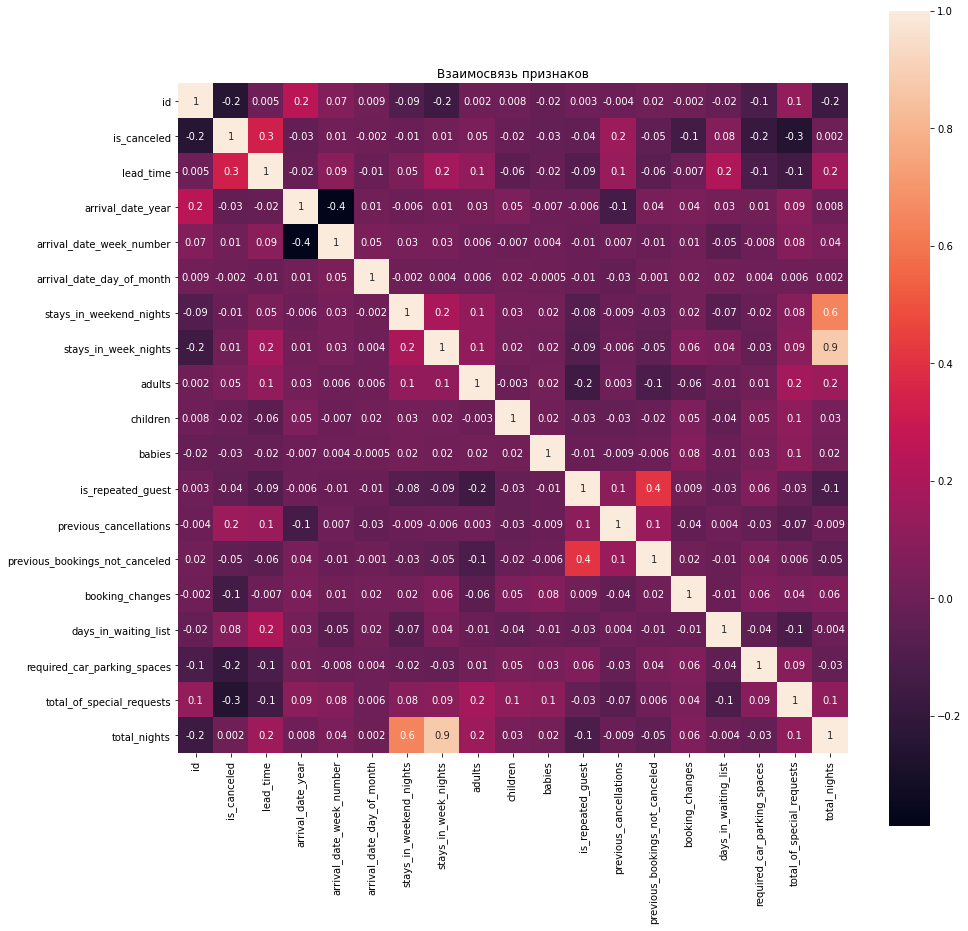

In [8]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(hotel_train.corr(),annot = True, fmt = '.1g', ax=ax, square=True)
plt.title('Взаимосвязь признаков')
plt.show() 

В наибольшей степени на целевой признак влияют признаки `lead_time`, `previous_cancellations`(прямая зависимость), `required_car_parking_spaces`, `total_of_special_requests`(обратная зависимость). Остальные признаки влияют менее значительно.

Также обратим внимание на мультиколлинеарность некоторых признаков, это такие пары как:

- `total_nights` - `stays_in_weekend_nights`
- `total_nights` - `stays_in_week_nights`
- `previous_bookings_not_canceled` - `is_repeated_guest`
- `arrival_date_week_number` - `arrival_date_year`


Мультиколлинеарность негативно влияет на модели машинного обучения, поэтому удалим по одному признаку из пары. также определим, какие признаки имеют значение для предсказания целевого признака - столбец id, country не будет влиять на результат, поэтому удаляем его:

In [9]:
hotel_train = hotel_train.drop(['id', 'country', 'stays_in_weekend_nights', 'stays_in_week_nights', 'previous_bookings_not_canceled', 'arrival_date_year'], axis=1)
hotel_test = hotel_test.drop(['id', 'country', 'stays_in_weekend_nights', 'stays_in_week_nights', 'previous_bookings_not_canceled', 'arrival_date_year'], axis=1)

Сохраним ключевые переменные для вычислений:

In [10]:
BUDGET = 400000
SUMMER_COEF = 0.4
DEMISEASON_COEF = 0.2
A_PRICE = 1000
A_SERVICE = 400
B_PRICE = 800
B_SERVICE = 350
C_PRICE = 600
C_SERVICE = 350
D_PRICE = 550
D_SERVICE = 150
E_PRICE = 500
E_SERVICE = 150
F_PRICE = 450
F_SERVICE = 150
G_PRICE = 350
G_SERVICE = 150
SUMMER_MONTHS = [ 'June', 'July', 'August' ]
DEMISEASON_MONTHS = ['September', 'October', 'November' , 'March', 'April', 'May']

Для удобства создалим датафрейм prices с ценами на уборку и номера:

In [11]:
prices = {'reserved_room_type' : ['A','B', 'C', 'D', 'E', 'F', 'G'], 'price': [A_PRICE, B_PRICE, C_PRICE, D_PRICE, E_PRICE, F_PRICE, G_PRICE], 'service' : [A_SERVICE, B_SERVICE, C_SERVICE, D_SERVICE, E_SERVICE, F_SERVICE, G_SERVICE]}
prices = pd.DataFrame(prices)
prices

,reserved_room_type,price,service
0,A,1000,400
1,B,800,350
2,C,600,350
3,D,550,150
4,E,500,150
5,F,450,150
6,G,350,150


Объединим датафреймы по столбцу `reserved_room_type`:

In [12]:
hotel_train = hotel_train.merge(prices, on='reserved_room_type', how='left')
hotel_test = hotel_test.merge(prices, on='reserved_room_type', how='left')

Посчитаем прибыль для каждого клиента, для этого сначала создадим отдельный столбец с сезонными коэффициентами:

In [13]:
def coef(row):
    month = row['arrival_date_month']
    if month in SUMMER_MONTHS:         # проверяем, находится ли месяц в списке
        return SUMMER_COEF
    elif month in DEMISEASON_MONTHS:   
        return DEMISEASON_COEF
    else:
        return 0        

In [14]:
hotel_train['coef'] = hotel_train.apply(coef, axis=1)
hotel_test['coef'] = hotel_test.apply(coef, axis=1)

затем определим функцию для подсчета прибыли с каждого клиента:

In [15]:
def calc_0(price, service, days, coef):
    res = (days * price * (coef+1)) - (days + 1)//2 * service # формула для расчета прибыли
    return res

def calc_1(price, service, coef):
    res = 0 - (price * (coef+1) + service)    # убыток в случае отмены бронирования      
    return res

def calc_deposit(price, service, coef):  # формула для расчета депозита в случае отмены
    res = (price * (coef+1)) *0.8 + service
    return res

In [16]:
 def income_before(row):
    room_type = row['reserved_room_type']  
    coef = row['coef']                     
    days = row['total_nights']             
    cancel = row['is_canceled']
    price = row['price']
    service = row['service']
    if cancel == 0:
        return calc_0(price, service, days, coef)
    else:
        return calc_1(price, service, coef) 

In [17]:
hotel_train['income_before'] = hotel_train.apply(income_before, axis=1)
hotel_test['income_before'] = hotel_test.apply(income_before, axis=1)
hotel_train.query("is_canceled == 0")['income_before'].sort_values()

64947      200.0
8983       200.0
16622      200.0
16619      200.0
16588      200.0
          ...   
13742    12000.0
13739    12000.0
54499    12000.0
6051     12000.0
4197     12000.0
Name: income_before, Length: 41185, dtype: float64

Преобразуем столбец с месяцами в числовой формат:

In [18]:
hotel_train['arrival_date_month'] = pd.to_datetime(hotel_train['arrival_date_month'], format='%B')
hotel_train['arrival_date_month'] = pd.DatetimeIndex(hotel_train['arrival_date_month']).month 
hotel_test['arrival_date_month'] = pd.to_datetime(hotel_test['arrival_date_month'], format='%B')
hotel_test['arrival_date_month'] = pd.DatetimeIndex(hotel_test['arrival_date_month']).month 
hotel_train['arrival_date_month'].unique()

array([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6])

Создадим фиктивные переменные для строковых переменных:

In [19]:
df_train = pd.get_dummies(hotel_train, drop_first=True)
df_test = pd.get_dummies(hotel_test, drop_first=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65229 entries, 0 to 65228
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   is_canceled                    65229 non-null  int64  
 1   lead_time                      65229 non-null  float64
 2   arrival_date_month             65229 non-null  int64  
 3   arrival_date_week_number       65229 non-null  int64  
 4   arrival_date_day_of_month      65229 non-null  int64  
 5   adults                         65229 non-null  float64
 6   children                       65229 non-null  float64
 7   babies                         65229 non-null  float64
 8   is_repeated_guest              65229 non-null  int64  
 9   previous_cancellations         65229 non-null  int64  
 10  booking_changes                65229 non-null  int64  
 11  days_in_waiting_list           65229 non-null  int64  
 12  required_car_parking_spaces    65229 non-null 

Проведём масштабирование признаков:

In [20]:
numeric = [
    'lead_time', 'adults', 'children', 'booking_changes', 'babies', 'days_in_waiting_list', 'previous_cancellations',
    'total_nights', 'total_of_special_requests', 'arrival_date_day_of_month', 'income_before'
    ]

scaler = StandardScaler()
scaler.fit(df_train[numeric])
df_train[numeric] = scaler.transform(df_train[numeric])
df_test[numeric] = scaler.transform(df_test[numeric])


pd.options.mode.chained_assignment = None

Определим целевой признак в обоих выборках:

In [21]:
features_train = df_train.drop(['is_canceled', 'income_before', 'coef', 'price', 'service'], axis=1)
target_train = df_train['is_canceled']
features_test = df_test.drop(['is_canceled',  'income_before', 'coef', 'price', 'service'], axis=1)
target_test = df_test['is_canceled']

#### Исследование задачи

Проверим, как часто в целевом признаке встречается класс «1» или «0»:

0    0.631391
1    0.368609
Name: is_canceled, dtype: float64


<AxesSubplot:>

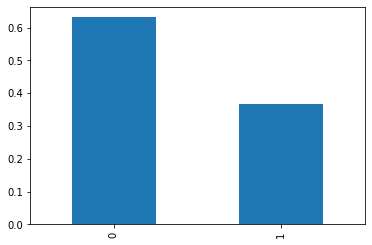

In [22]:
class_frequency = df_train['is_canceled'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar') 

Соотношение отменивших бронь клиентов:

In [23]:
print(class_frequency[1]/class_frequency[0])

0.5838047832948888


Для устранения дисбаланса классов в дальнейшем будем использовать метод изменения порога.

## Вычисление бизнес-метрики

Оценим прибыль отеля без внедрения депозитов:

In [24]:
income_before = hotel_test['income_before'].sum() / 8 * 12
print('Прибыль до внедрения депозитов: ', int(income_before), 'руб.')

Прибыль до внедрения депозитов:  52951155 руб.


##  Формулировка ML-задачи на основе бизнес-задачи

Требуется обучить и настроить несколько моделей, затем выбрать из них ту, которая будет имень наибольшее значение *F-1 меры*, а так же площади под ROC-кривой. Рассмотрим следующие модели:

 - логистическая регрессия
 - дерево решений
 - случайный лес
 
В качестве метода устранения дисбаланса будет использовано изменение порога. 

##  Разработка модели ML

При сравнении моделей в качестве определяющей метрики будем использовать точность (*precision*), тк она показывает долю истинно положительных ответов, то есть те бронирования, которые действительно будут отменены -  будет важно получить как можно более точное число отмененных бронирований.

Для вычисления метрик и построения кривой определим функцию metrics_func:

In [25]:
def metrics_func(model):
    model.fit(features_train, target_train)
    predicted_test = model.predict(features_test)
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    precision_best = 0
    threshold_best = 0
    predicted_test_best = 0
    for threshold in np.arange(0, 0.35, 0.01):
        predicted_test = probabilities_one_test > threshold
        precision = precision_score(target_test, predicted_test)
        if precision > precision_best:
            precision_best = precision
            threshold_best = threshold
            predicted_test_best = predicted_test
            model_best = model
    print('Точность:', precision_best, 'при пороге равном', threshold_best)
    print('Доля правильных ответов:', accuracy_score(target_test, predicted_test_best)) 
    print('F1-мера:', f1_score(target_test, predicted_test_best))
    print('AUC-ROC:', roc_auc_score(target_test, probabilities_one_test))
    print('Матрица ошибок:')
    print(confusion_matrix(target_test, predicted_test_best))
    #print(predicted_test_best)
    #print(classification_report(target_test, predicted_test_best))

# строим ROC-кривую
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

    plt.figure()

    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    
    plt.show()
    return predicted_test_best, probabilities_one_test, model

### Логистическая регрессия

C помощью функции *cross_val_score* рассмотрим средние оценки качества модели:

In [26]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
scores_train = cross_val_score(model_lr, features_train, target_train, cv=5)
print('Средняя оценка качества модели на обучающей выборке:', scores_train.mean())

Средняя оценка качества модели на обучающей выборке: 0.7087800275312047


Точность: 0.5742497924326889 при пороге равном 0.34
Доля правильных ответов: 0.6887881031716648
F1-мера: 0.6575221539401759
AUC-ROC: 0.7787291986413978
Матрица ошибок:
[[12642  7179]
 [ 2908  9683]]


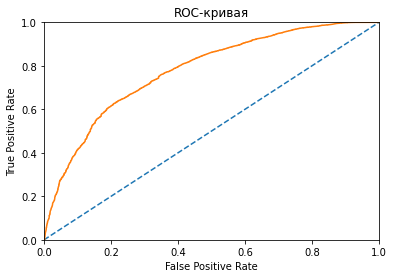

In [27]:
predictions_lr, probabilities_lr, model_lr = metrics_func(LogisticRegression(random_state=12345, solver='liblinear'))

### Дерево решений

Подберем оптимальные параметры с помощью GridSearchCV:

In [28]:
params_tree = {'max_depth': range (1, 11, 2)}

tree = DecisionTreeClassifier()
grid_tree = GridSearchCV(tree, params_tree)
grid_tree.fit(features_train, target_train)

print(grid_tree.best_params_)

{'max_depth': 5}


C помощью функции *cross_val_score* рассмотрим средние оценки качества модели:

Точность: 0.6412123264476803 при пороге равном 0.33
Доля правильных ответов: 0.7144576082932247
F1-мера: 0.6207433512273082
AUC-ROC: 0.7616444499371751
Матрица ошибок:
[[15583  4238]
 [ 5017  7574]]


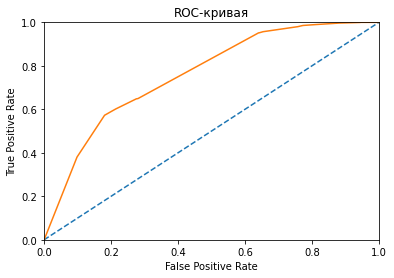

In [29]:
predictions_dt, probabilities_dt, model_dt  = metrics_func(DecisionTreeClassifier(max_depth=5, random_state=12345))

### Случайный лес

Подберем оптимальные параметры с помощью GridSearchCV:

C помощью функции *cross_val_score* рассмотрим средние оценки качества модели:

Точность: 0.5992344768925433 при пороге равном 0.34
Доля правильных ответов: 0.697920523262989
F1-мера: 0.633282145398704
AUC-ROC: 0.7683521909141778
Матрица ошибок:
[[14167  5654]
 [ 4137  8454]]


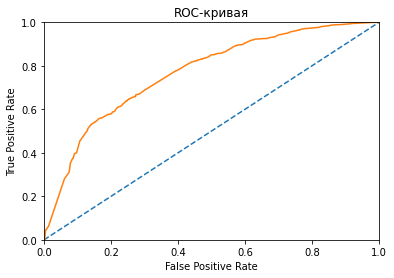

In [30]:
predictions_rf, probabilities_rf, model_rf = metrics_func(RandomForestClassifier(n_estimators=30, max_depth=3, random_state=12345))

## Оценка прибыли

In [31]:
 def income_after(row):
    room_type = row['reserved_room_type']  
    coef = row['coef']                     
    days = row['total_nights']             
    cancel = row['is_canceled']
    price = row['price']
    service = row['service']
    predictions = row['predictions']
    if cancel*predictions == 0:
        return calc_0(price, service, days, coef)
    else:
        return calc_deposit(price, service, coef)

In [32]:
hotel_test['predictions'] = predictions_dt*1 # добавим столбец с предсказаниями в тестовую выборку

hotel_test['income_after'] = hotel_test.apply(income_after, axis=1)
income_after = hotel_test['income_after'].sum() / 8 * 12
print('Прибыль до внедрения депозитов: ', int(income_before), 'руб.')
print('Прогнозируемая прибыль после внедрения депозитов:', int(income_after), 'руб.')
print('Разность прибылей после и до внедрения: ', int(income_after-income_before), 'руб.')

Прибыль до внедрения депозитов:  52951155 руб.
Прогнозируемая прибыль после внедрения депозитов: 116089275 руб.
Разность прибылей после и до внедрения:  63138120 руб.


In [33]:
#код ревьюера
pd.Series(predictions_dt).value_counts()

False    20600
True     11812
dtype: int64

In [34]:
#код ревьюера
pd.Series(target_test).value_counts()

0    19821
1    12591
Name: is_canceled, dtype: int64

## Портрет «ненадёжного» клиента

Для описания ненадёжного клиента воспользуемся функцией SelectFromModel:

In [35]:
smf = SelectFromModel(model_rf, threshold=-np.inf, max_features = 7)
smf.fit(features_train, target_train)
features_index = smf.get_support()
features_1 = features_train.columns[features_index]
features_1

Index(['lead_time', 'previous_cancellations', 'booking_changes',
       'required_car_parking_spaces', 'total_of_special_requests',
       'distribution_channel_TA/TO', 'customer_type_Transient-Party'],
      dtype='object')

По итогам исследования, можно описать тип ненадежного клиента - вероятность отмены бронирования повышается, если:

- большое количество дней между датой бронирования и датой прибытия;
- у клиента ранее уже были отмены;
- большое количество изменений параметров заказа;
- клиенту требуется большее кол-во парковочных мест;
- большое количество специальных отметок;
- бронирование происходило через туристическое агентство; 
- бронирование не связано с договором или групповым заездом.


### Общий вывод

В результате сравнения полученных моделей наилучший результат показывает модель решающего дерева, тк она имеет наибольшее значение точности для выбранного порога, а точность показывает долю истинно положительных ответов, то есть те бронирования, которые действительно будут отменены:
- F1-мера: 0.620
- AUC-ROC: 0.761
- Precision (точность): 0.641    
- Доля правильных ответов: 0.714


Прибыль после внедрения депозитов увеличилась более чем в 2 раза, что полностью покрывает расходы на разработку модели:
- Прибыль до внедрения депозитов:  52951155 руб.
- Прогнозируемая прибыль после внедрения депозитов: 116089275 руб.